## Antoencoder plus GMM
### Import packages

In [1]:
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture

import torch
from torch import nn,optim

In [2]:
path = Path.home().joinpath("Documents","Data","Rehabilitation")
X = pd.read_csv(path.joinpath("Data_Correct.csv"),header=None)
Y = pd.read_csv(path.joinpath("Data_Incorrect.csv"),header=None)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,-0.007968,-0.007596,-0.007147,-0.006632,-0.006065,-0.005463,-0.004840,-0.004211,-0.003592,-0.002997,...,0.022263,0.022386,0.022453,0.022462,0.022413,0.022305,0.022139,0.021916,0.021637,0.021306
1,-0.053214,-0.053852,-0.054411,-0.054885,-0.055271,-0.055564,-0.055759,-0.055853,-0.055843,-0.055728,...,0.060776,0.061385,0.061918,0.062374,0.062751,0.063050,0.063271,0.063418,0.063496,0.063511
2,-0.011795,-0.011839,-0.011834,-0.011784,-0.011692,-0.011562,-0.011398,-0.011204,-0.010984,-0.010742,...,-0.019779,-0.019992,-0.020218,-0.020456,-0.020704,-0.020962,-0.021228,-0.021499,-0.021774,-0.022051
3,0.053393,0.054030,0.054587,0.055059,0.055441,0.055730,0.055921,0.056010,0.055994,0.055873,...,-0.060639,-0.061242,-0.061769,-0.062218,-0.062587,-0.062877,-0.063090,-0.063228,-0.063296,-0.063300
4,-0.007061,-0.006686,-0.006235,-0.005718,-0.005152,-0.004551,-0.003930,-0.003304,-0.002689,-0.002098,...,0.023281,0.023424,0.023513,0.023546,0.023523,0.023442,0.023305,0.023112,0.022864,0.022564


In [3]:
X = X.to_numpy()
Y = Y.to_numpy()
print(X.shape)
print(Y.shape)

(10530, 240)
(10530, 240)


### Transform data to be in size (240x90)x117

In [4]:
n_dim = 117
T = X.shape[1]
R = int(X.shape[0]/n_dim)
def two2three(X, R, T, n_dim):
    X_NN = np.zeros((R,T,n_dim))
    for r in range(R):
        X_NN[r,:,:] = X[r*n_dim:(r+1)*n_dim,:].T
    return X_NN

In [5]:
X_NN = two2three(X, R, T, n_dim)
Y_NN = two2three(Y, R, T, n_dim)
print(X_NN.shape)
print(Y_NN.shape)

(90, 240, 117)
(90, 240, 117)


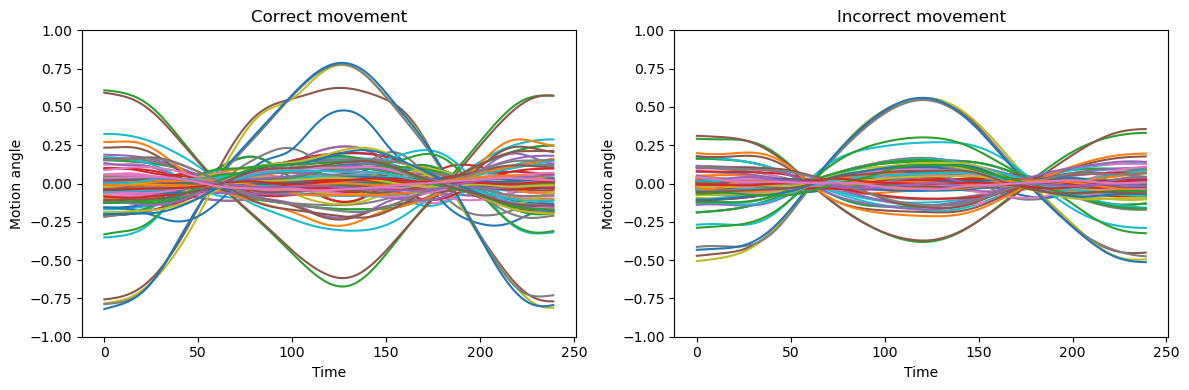

In [6]:
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(X_NN[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Correct movement")
plt.subplot(1,2,2)
plt.plot(Y_NN[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Incorrect movement")
plt.tight_layout()
plt.show()

### Extend data
Add 50 time frames at the beginning and end of sequences as the autoencoder has difficulties with the beginning and ending frames.

In [7]:
X_NN_add = np.zeros((R,T+100,n_dim))
for r in range(R):
    for d in range(n_dim):
        X_NN_add[r,:,d] = np.pad(X_NN[r,:,d],50,"edge")
print(X_NN_add.shape)

(90, 340, 117)


In [8]:
Y_NN_add = np.zeros((R,T+100,n_dim))
for r in range(R):
    for d in range(n_dim):
        Y_NN_add[r,:,d] = np.pad(Y_NN[r,:,d],50,"edge")
print(Y_NN_add.shape)

(90, 340, 117)


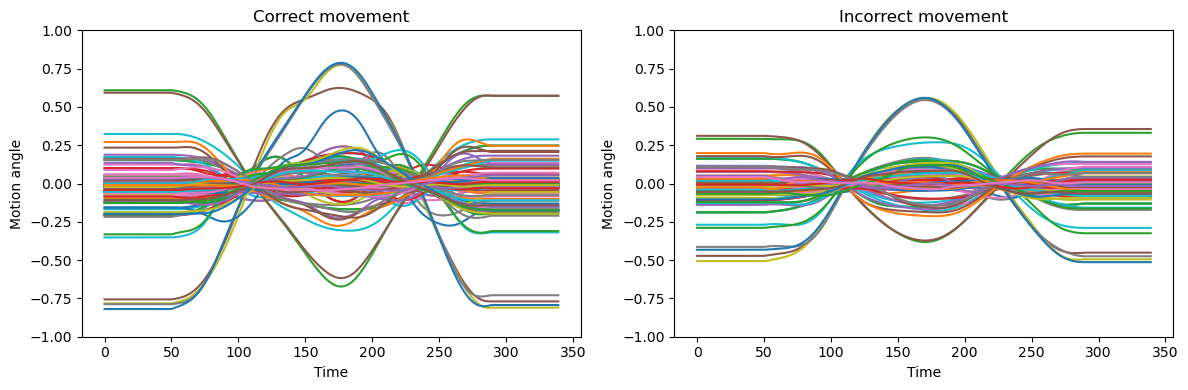

In [9]:
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(X_NN_add[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Correct movement")
plt.subplot(1,2,2)
plt.plot(Y_NN_add[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Incorrect movement")
plt.tight_layout()
plt.show()

### Build autoencoder model
input = [batch_size,sen_len,input_size]

nn.LSTM(input_size, hidden_size, batch_first=True)

In [10]:
X_NN_add = torch.tensor(X_NN_add).float()
Y_NN_add = torch.tensor(Y_NN_add).float()

In [11]:
class AE(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        # encoder layers
        self.en1 = nn.LSTM(n_dim,30,batch_first=True)
        self.en2 = nn.LSTM(30,10,batch_first=True)
        self.en3 = nn.LSTM(10,4,batch_first=True)
        # decoder layers
        self.de1 = nn.LSTM(4,10,batch_first=True)
        self.de2 = nn.LSTM(10,30,batch_first=True)
        self.de3 = nn.LSTM(30,n_dim,batch_first=True)
        
    def encoder(self,x):
        
        en,(_,_) = self.en1(x)
        en,(_,_) = self.en2(en)
        en,(_,_) = self.en3(en)
        
        return en
    
    def decoder(self,x):
        
        de,(_,_) = self.de1(x)
        de,(_,_) = self.de2(de)
        de,(_,_) = self.de3(de)
        
        return de
        
    def forward(self,x):
        
        en = self.encoder(x)
        x_ = self.decoder(en)
        
        return x_

In [12]:
ae = AE(n_dim)
print(ae)

AE(
  (en1): LSTM(117, 30, batch_first=True)
  (en2): LSTM(30, 10, batch_first=True)
  (en3): LSTM(10, 4, batch_first=True)
  (de1): LSTM(4, 10, batch_first=True)
  (de2): LSTM(10, 30, batch_first=True)
  (de3): LSTM(30, 117, batch_first=True)
)


In [13]:
en = ae.encoder(X_NN_add)
de = ae(X_NN_add)
print(en.shape)
print(de.shape)

torch.Size([90, 340, 4])
torch.Size([90, 340, 117])


In [14]:
trainidx = random.sample(range(0,R),63)
# return index which is in np.arange(0,90,1) but not in trainidx
valididx = np.setdiff1d(np.arange(0,90,1),trainidx)
print("train index: ", trainidx)
print("valid index: ", valididx)

train index:  [24, 22, 60, 48, 50, 13, 0, 21, 14, 59, 26, 72, 66, 89, 2, 47, 69, 9, 79, 1, 83, 57, 3, 7, 62, 23, 77, 53, 36, 41, 56, 27, 6, 88, 49, 37, 44, 54, 78, 31, 12, 38, 73, 28, 68, 85, 11, 67, 42, 10, 80, 16, 5, 52, 74, 35, 34, 43, 29, 70, 81, 55, 58]
valid index:  [ 4  8 15 17 18 19 20 25 30 32 33 39 40 45 46 51 61 63 64 65 71 75 76 82
 84 86 87]


In [15]:
train = X_NN_add[trainidx,:,:]
valid = X_NN_add[valididx,:,:]
print(train.shape)
print(valid.shape)

torch.Size([63, 340, 117])
torch.Size([27, 340, 117])


### Train the autoencoder model

In [16]:
optimizer = optim.AdamW(ae.parameters())
mse = nn.MSELoss()

In [17]:
history = {"train":[],"valid":[]}
for i in tqdm(range(1000)):
    
    # update network
    optimizer.zero_grad()
    de = ae(train)
    loss = mse(train,de)
    loss.backward()
    optimizer.step()
    history["train"].append(loss.item())
    
    # valid loss
    de_val = ae(valid)
    loss_val = mse(valid,de_val)
    history["valid"].append(loss_val.item())

100%|██████████| 1000/1000 [06:57<00:00,  2.40it/s]


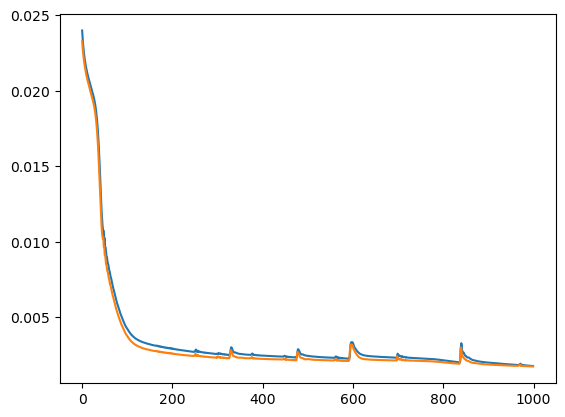

In [18]:
plt.plot(history["train"],label="train")
plt.plot(history["valid"],label="valid")
plt.show()

In [19]:
print(history["train"][-1])
print(history["valid"][-1])

0.0017783645307645202
0.0017487402074038982


In [20]:
X_4_ = ae.encoder(X_NN_add)
X_de_ = ae(X_NN_add)
Y_4_ = ae.encoder(Y_NN_add)
Y_de_ = ae(Y_NN_add)
X_4_ = X_4_.detach().numpy()
Y_4_ = Y_4_.detach().numpy()
X_de_ = X_de_.detach().numpy()
Y_de_ = Y_de_.detach().numpy()
print(X_4_.shape)
print(X_de_.shape)
print(Y_4_.shape)
print(Y_de_.shape)

(90, 340, 4)
(90, 340, 117)
(90, 340, 4)
(90, 340, 117)


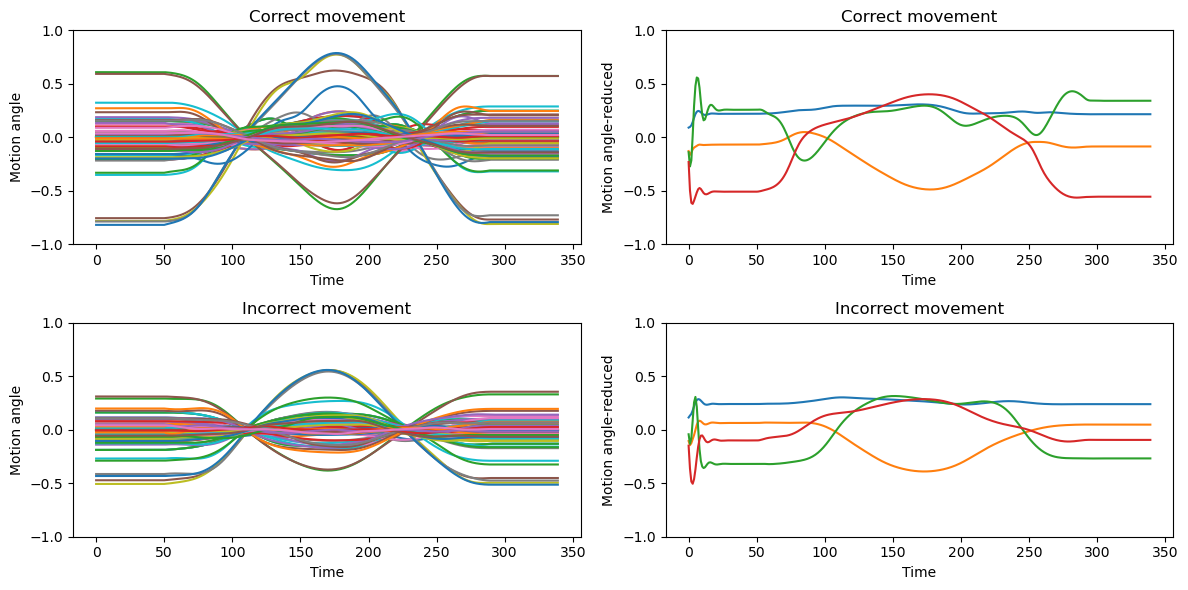

In [21]:
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,6))
#
plt.subplot(2,2,1)
plt.plot(X_NN_add[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Correct movement")
#
plt.subplot(2,2,2)
plt.plot(X_4_[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle-reduced")
plt.title("Correct movement")
#
plt.subplot(2,2,3)
plt.plot(Y_NN_add[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Incorrect movement")
#
plt.subplot(2,2,4)
plt.plot(Y_4_[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle-reduced")
plt.title("Incorrect movement")
#
plt.tight_layout()
plt.show()

In [22]:
# remove the added first 50 and last 50 elements
X_4 = X_4_[:,50:-50,:]
Y_4 = Y_4_[:,50:-50,:]
print(X_4.shape)
print(Y_4.shape)

(90, 240, 4)
(90, 240, 4)


In [23]:
X_de = X_de_[:,50:-50,:]
Y_de = Y_de_[:,50:-50,:]
print(X_de.shape)
print(Y_de.shape)

(90, 240, 117)
(90, 240, 117)


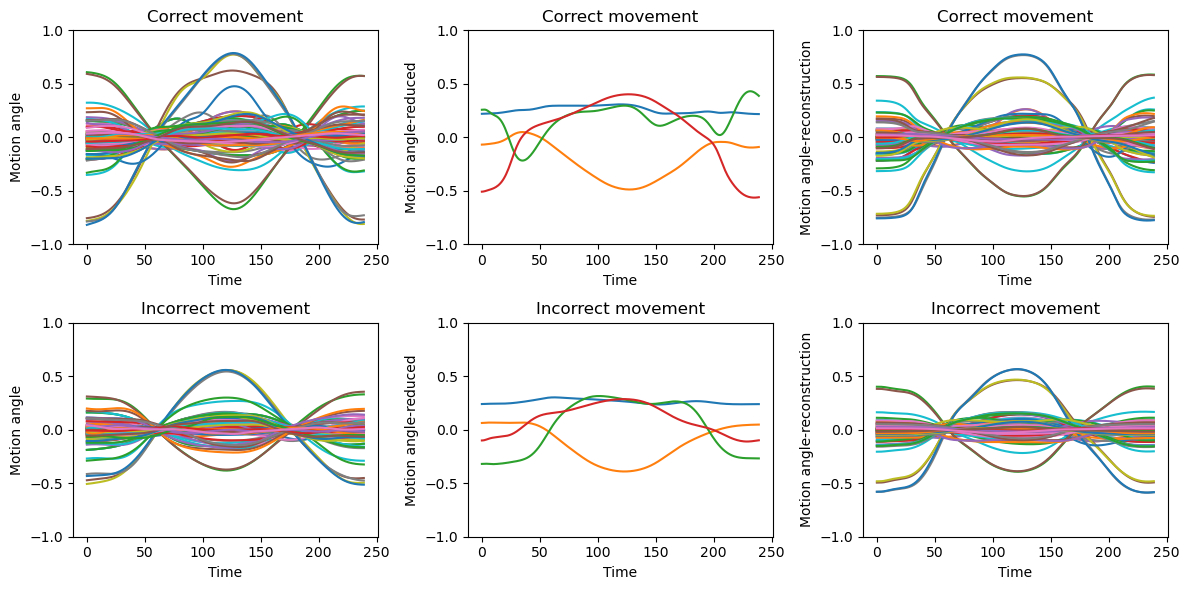

In [24]:
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,6))
#
plt.subplot(2,3,1)
plt.plot(X_NN[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Correct movement")
# 
plt.subplot(2,3,2)
plt.plot(X_4[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle-reduced")
plt.title("Correct movement")
#
plt.subplot(2,3,3)
plt.plot(X_de[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle-reconstruction")
plt.title("Correct movement")
#
plt.subplot(2,3,4)
plt.plot(Y_NN[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Incorrect movement")
#
plt.subplot(2,3,5)
plt.plot(Y_4[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle-reduced")
plt.title("Incorrect movement")
#
plt.subplot(2,3,6)
plt.plot(Y_de[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle-reconstruction")
plt.title("Incorrect movement")
#
plt.tight_layout()
plt.show()

### Train a GMM by sklearn

In [25]:
def trans2twod(X):
    ind3 = X.shape[2]
    X_ = X.reshape(-1,ind3)
    return X_

In [26]:
X_4_long = trans2twod(X_4)
Y_4_long = trans2twod(Y_4)
print(f"\n{X_4_long.shape = }")
print(f"\n{Y_4_long.shape = }")


X_4_long.shape = (21600, 4)

Y_4_long.shape = (21600, 4)


In [27]:
print(X_4_long[240,:] == X_4[1,0,:])
print(Y_4_long[240,:] == Y_4[1,0,:])

[ True  True  True  True]
[ True  True  True  True]


In [28]:
gmm = GaussianMixture(n_components=6,n_init=10,init_params='kmeans')
gmm.fit(X_4_long)

GaussianMixture(n_components=6, n_init=10)

In [29]:
print("weights: ", gmm.weights_)
print("means: ", gmm.means_)
print("covariances: ", gmm.covariances_)

weights:  [0.23793039 0.19152831 0.27680445 0.19139703 0.03209182 0.07024799]
means:  [[ 0.28305313 -0.41925047  0.29529198  0.33418599]
 [ 0.24288545 -0.04755617  0.23788863 -0.36467128]
 [ 0.27734571 -0.17798851  0.18293086  0.17404934]
 [ 0.24370166 -0.00945713 -0.04131203 -0.06214017]
 [ 0.32368373 -0.09005609  0.82047002 -0.22266894]
 [ 0.30591127 -0.29815111 -0.07325573  0.38024132]]
covariances:  [[[ 1.86411763e-03 -3.23074388e-03  5.53258840e-03  2.67703871e-03]
  [-3.23074388e-03  1.04813657e-02 -1.36929884e-02 -7.08532894e-03]
  [ 5.53258840e-03 -1.36929884e-02  2.54987753e-02  8.45572074e-03]
  [ 2.67703871e-03 -7.08532894e-03  8.45572074e-03  5.66461723e-03]]

 [[ 1.26655095e-03  6.68057294e-04  3.92510786e-03  5.39783030e-03]
  [ 6.68057294e-04  1.18088754e-03 -2.90857146e-03  4.84717024e-03]
  [ 3.92510786e-03 -2.90857146e-03  4.34767405e-02  3.39976491e-03]
  [ 5.39783030e-03  4.84717024e-03  3.39976491e-03  3.07192007e-02]]

 [[ 6.48233376e-04  7.86223266e-05  1.2686956

In [30]:
print("Converge or not: ", gmm.converged_)
print("Maximal iteration: ", gmm.n_iter_)

Converge or not:  True
Maximal iteration:  13


### Calculate negative likelihood

In [31]:
def trans2threed(X, R, T):
    ind2 = X.shape[1]
    X_ = np.zeros((R,T,ind2))
    for r in range(R):
        X_[r,:,:] = X[r*T:(r+1)*T,:]
    return X_

# this function is corret but we do not need it.
(X_4 == trans2threed(X_4_long, R, T)).all()

True

In [32]:
# average(over time) log likelihood, instead of average negative log likelihood
print(gmm.score(X_4[0,:,:]))
print(gmm.score(Y_4[0,:,:]))

6.551637940141415
5.9194566789716845


In [33]:
lik = defaultdict(list)
for r in range(R):
    lik["corr"].append(gmm.score(X_4[r,:,:]))
    lik["incorr"].append(gmm.score(Y_4[r,:,:]))

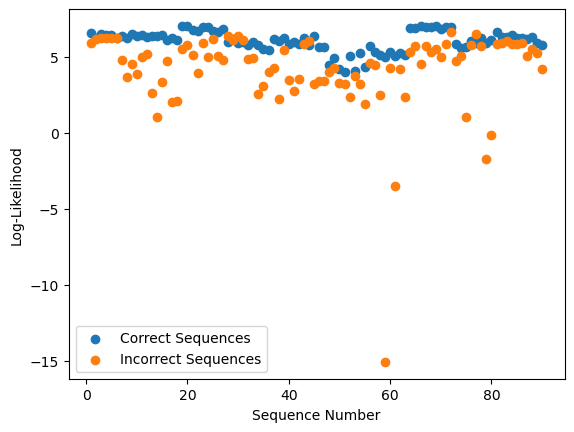

In [34]:
plt.scatter(np.arange(1,91),lik["corr"], label = "Correct Sequences")
plt.scatter(np.arange(1,91),lik["incorr"], label = "Incorrect Sequences")
plt.xlabel("Sequence Number")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.show()